In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("//content/energydata.csv")


In [9]:
print("✅ Data loaded successfully!")
print("Columns available:\n", df.columns.tolist())
print("\nShape:", df.shape)
print("\nSample data:\n", df.head())


✅ Data loaded successfully!
Columns available:
 ['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']

Shape: (19735, 29)

Sample data:
                   date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19

In [10]:
date_col = [c for c in df.columns if 'date' in c.lower()][0]
df[date_col] = pd.to_datetime(df[date_col])

In [11]:
df = df.sort_values(by=date_col)


In [12]:
df = df.set_index(date_col)


In [13]:
target_col = 'Appliances'  # adjust if your dataset differs
data = df[target_col]

In [14]:
data = data.resample('H').mean().interpolate()


In [15]:
print("\n✅ Preprocessing done!")
print("Data start:", data.index.min())
print("Data end:", data.index.max())


✅ Preprocessing done!
Data start: 2016-01-11 17:00:00
Data end: 2016-05-27 18:00:00


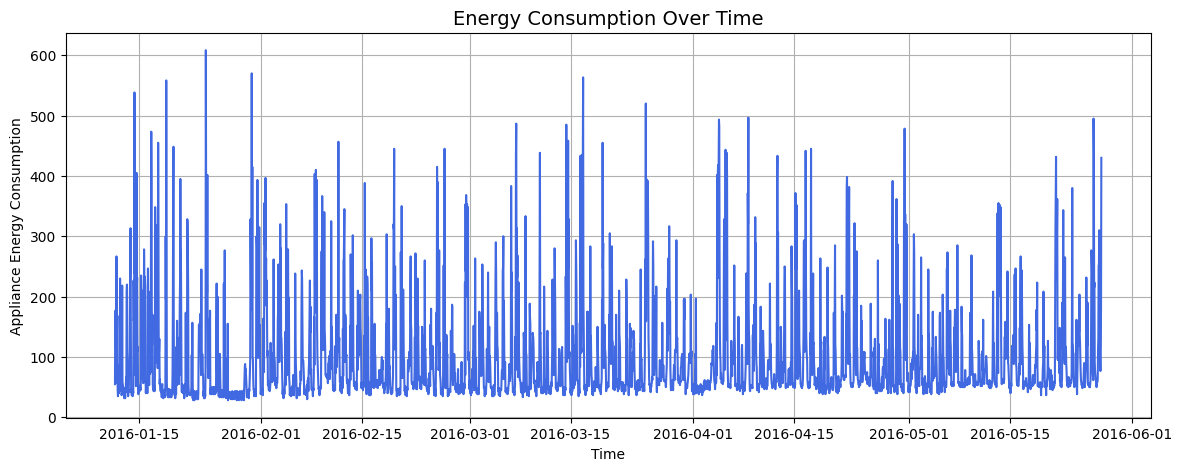

In [16]:
plt.figure(figsize=(14,5))
plt.plot(data, color='royalblue')
plt.title("Energy Consumption Over Time", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Appliance Energy Consumption")
plt.grid(True)
plt.show()

In [17]:
rolling_mean = data.rolling(window=24).mean()
rolling_std = data.rolling(window=24).std()

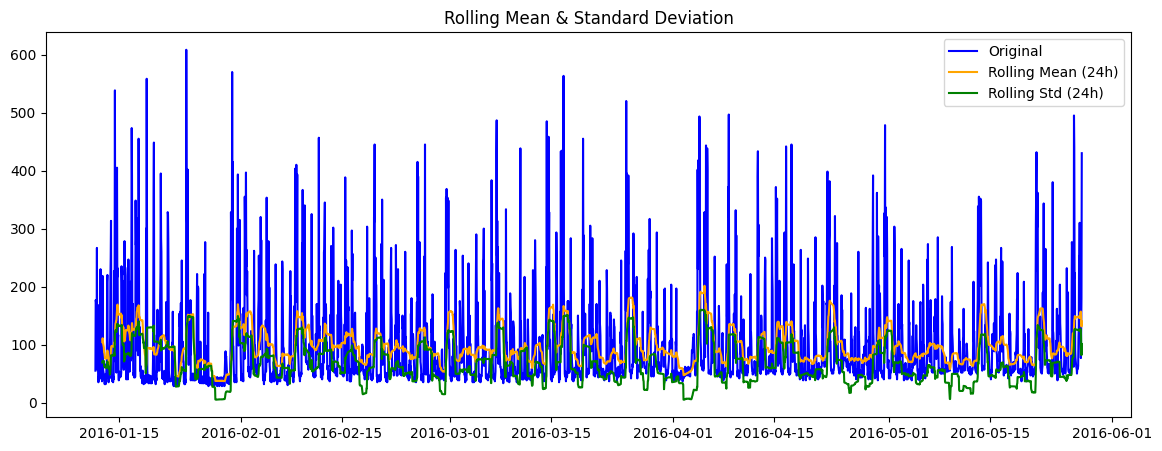

In [18]:
plt.figure(figsize=(14,5))
plt.plot(data, label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (24h)', color='orange')
plt.plot(rolling_std, label='Rolling Std (24h)', color='green')
plt.title("Rolling Mean & Standard Deviation")
plt.legend()
plt.show()

In [19]:
split_ratio = 0.8
split_point = int(len(data) * split_ratio)
train, test = data[:split_point], data[split_point:]

print("Training data:", train.shape)
print("Testing data:", test.shape)

Training data: (2632,)
Testing data: (658,)


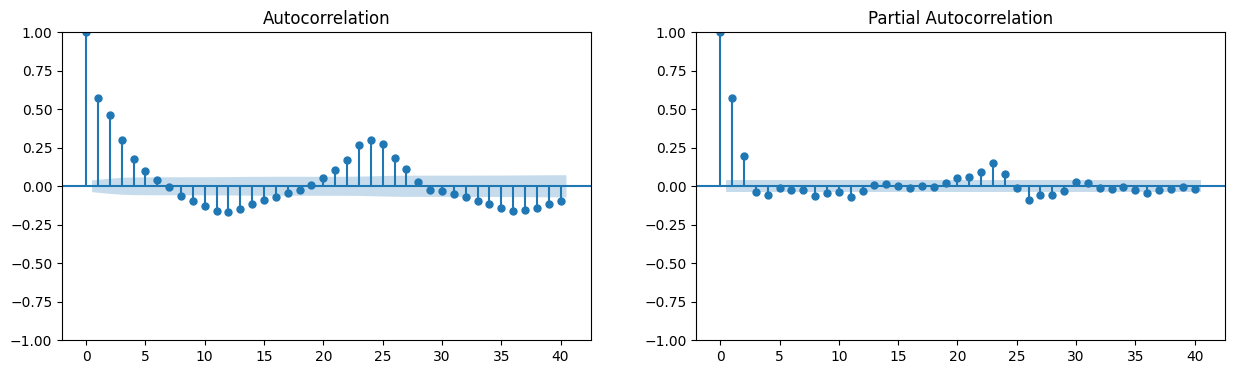

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
plot_acf(train, lags=40, ax=axes[0])
plot_pacf(train, lags=40, ax=axes[1])
plt.show()

In [21]:
model = ARIMA(train, order=(1,1,1))
fitted_model = model.fit()

In [22]:
print("\n✅ ARIMA Model Summary:")
print(fitted_model.summary())


✅ ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Appliances   No. Observations:                 2632
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14853.422
Date:                Sat, 08 Nov 2025   AIC                          29712.844
Time:                        11:06:19   BIC                          29730.470
Sample:                    01-11-2016   HQIC                         29719.227
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5755      0.011     53.851      0.000       0.555       0.596
ma.L1         -0.9999      0.026    -38.605      0.000      -1.051      -0.949
sigma2      4677.6103    150

In [23]:
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)
forecast.index = test.index

In [24]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"\nModel Performance:\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}")




Model Performance:
MAE = 48.76
RMSE = 70.11


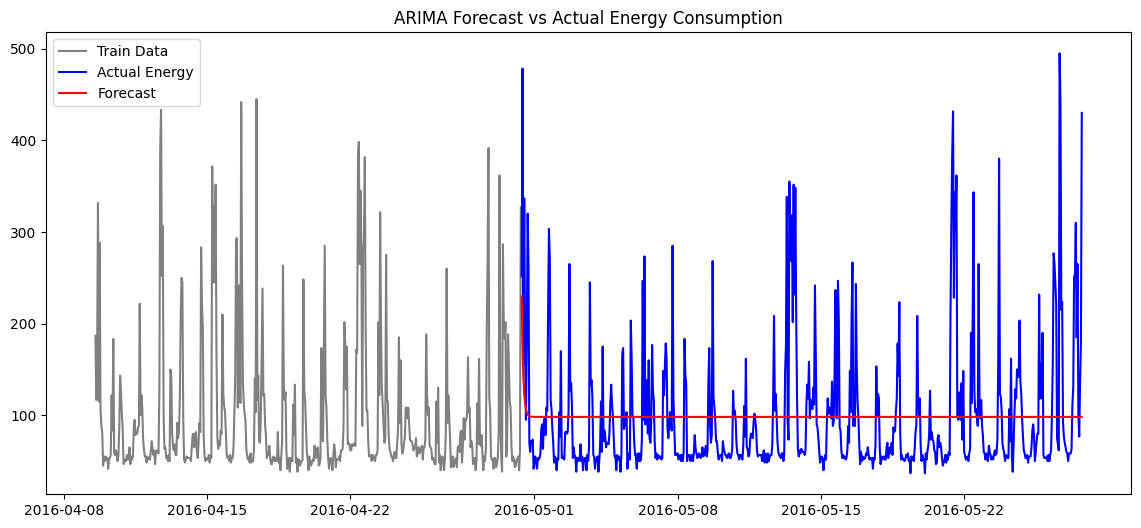

In [25]:
plt.figure(figsize=(14,6))
plt.plot(train[-500:], label="Train Data", color='gray')
plt.plot(test, label="Actual Energy", color='blue')
plt.plot(forecast, label="Forecast", color='red')
plt.title("ARIMA Forecast vs Actual Energy Consumption")
plt.legend()
plt.show()

In [26]:
future_steps = 48
future_forecast = fitted_model.forecast(steps=future_steps)

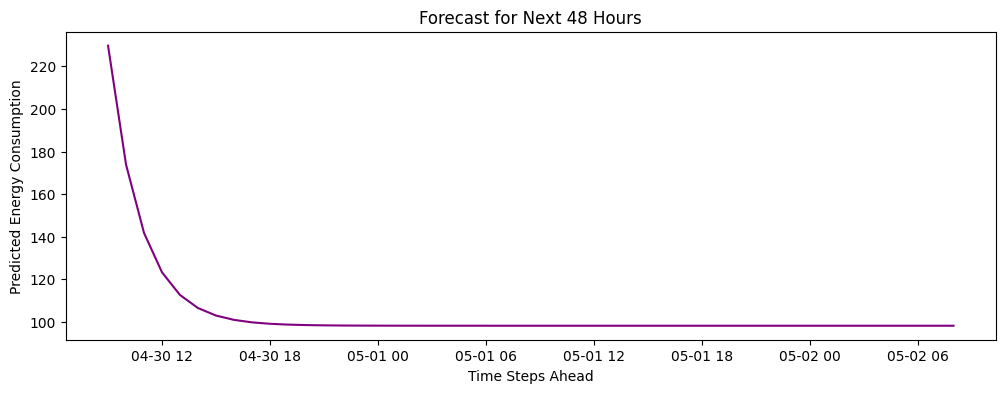

In [27]:
plt.figure(figsize=(12,4))
plt.plot(future_forecast, color='purple')
plt.title("Forecast for Next 48 Hours")
plt.xlabel("Time Steps Ahead")
plt.ylabel("Predicted Energy Consumption")
plt.show()

In [28]:
import pickle

# Save the trained ARIMA model
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(fitted_model, f)


In [29]:
with open('arima_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [30]:
# Forecast next 10 values
forecast = loaded_model.forecast(steps=10)
print(forecast)


2016-04-30 09:00:00    229.677298
2016-04-30 10:00:00    173.859669
2016-04-30 11:00:00    141.736482
2016-04-30 12:00:00    123.249506
2016-04-30 13:00:00    112.610205
2016-04-30 14:00:00    106.487259
2016-04-30 15:00:00    102.963489
2016-04-30 16:00:00    100.935550
2016-04-30 17:00:00     99.768466
2016-04-30 18:00:00     99.096806
Freq: h, Name: predicted_mean, dtype: float64
